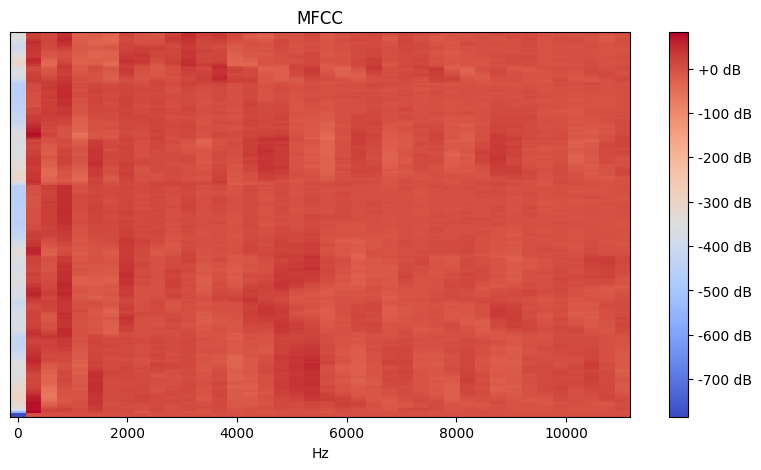

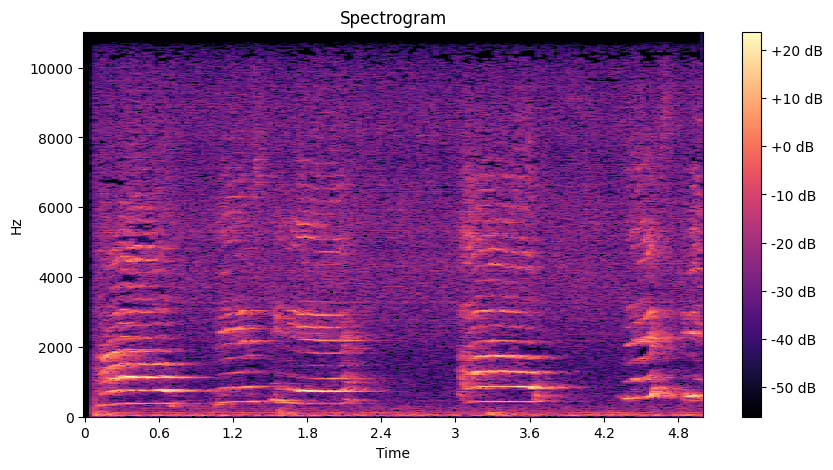

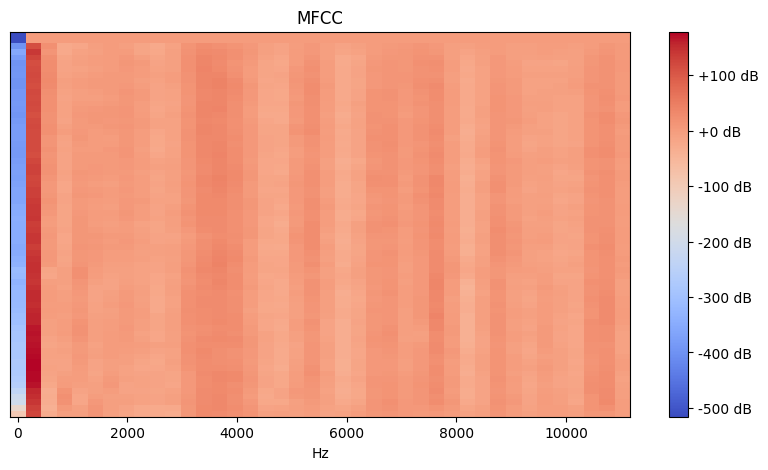

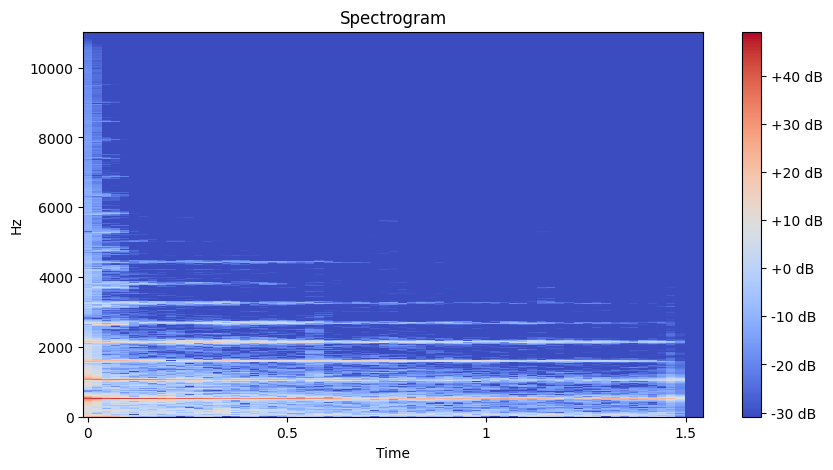

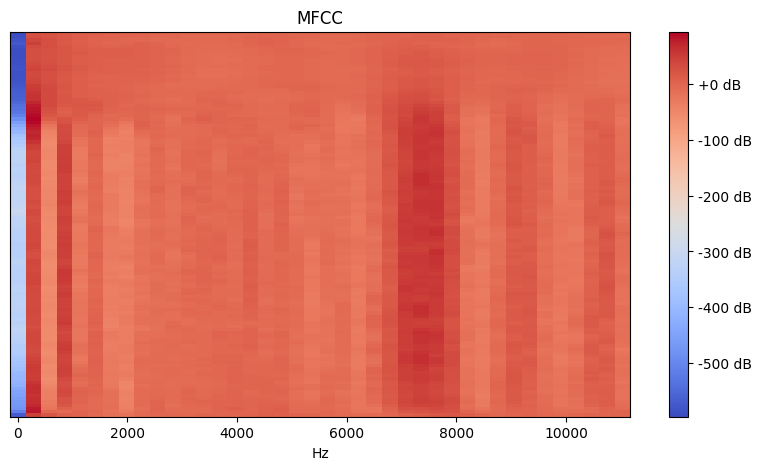

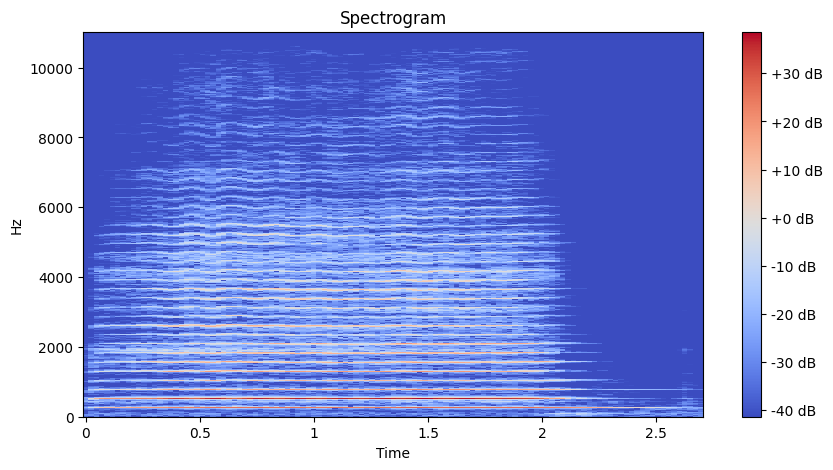

Epoch 1/50
1/1 [==============================] - ETA: 0s - loss: 2.9666 - accuracy: 0.5000
Epoch 1: val_accuracy improved from -inf to 0.00000, saving model to best_model.h5
1/1 [==============================] - 1s 1s/step - loss: 2.9666 - accuracy: 0.5000 - val_loss: 9.6493 - val_accuracy: 0.0000e+00
Epoch 2/50
1/1 [==============================] - ETA: 0s - loss: 30.0688 - accuracy: 0.0000e+00

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 2: val_accuracy did not improve from 0.00000
1/1 [==============================] - 0s 143ms/step - loss: 30.0688 - accuracy: 0.0000e+00 - val_loss: 40.8064 - val_accuracy: 0.0000e+00
Epoch 3/50
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 3: val_accuracy did not improve from 0.00000
1/1 [==============================] - 0s 122ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 51.8194 - val_accuracy: 0.0000e+00
Epoch 4/50
1/1 [==============================] - ETA: 0s - loss: 10.0437 - accuracy: 0.5000
Epoch 4: val_accuracy did not improve from 0.00000
1/1 [==============================] - 0s 132ms/step - loss: 10.0437 - accuracy: 0.5000 - val_loss: 52.4170 - val_accuracy: 0.0000e+00
Epoch 5/50
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 5: val_accuracy did not improve from 0.00000
1/1 [==============================] - 0s 112ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_l

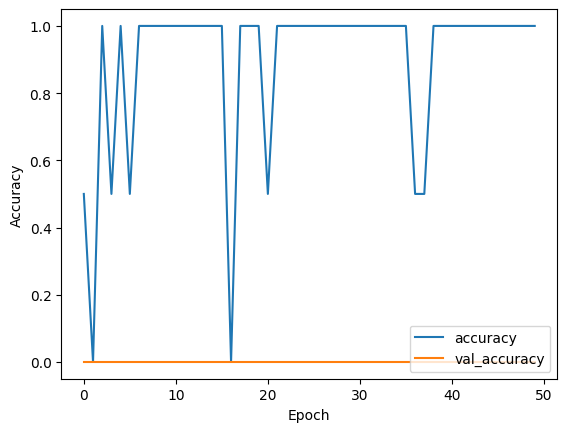

In [ ]:
import numpy as np
import librosa
import IPython.display as Ipd
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, LSTM, Dense, Dropout, Flatten
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt


def extract_features(audio_file, max_pad_len=174):
    y, sr = librosa.load(audio_file, duration=5)  # Load audio file, limit to 5 seconds

    # Calculate MFCCs
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
    mfccs = mfccs.T

    #plot MFCC
    plt.figure(figsize=(10,5))
    librosa.display.specshow(mfccs, sr=sr, x_axis='linear')
    plt.colorbar(format='%+2.0f dB')
    plt.title('MFCC')
    plt.show()

    # Calculate spectrogram
    spectrogram = np.abs(librosa.stft(y))
    spectrogram = librosa.amplitude_to_db(spectrogram)

    # Plot spectrogram
    plt.figure(figsize=(10, 5))
    librosa.display.specshow(spectrogram, sr=sr, x_axis='time', y_axis='linear')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Spectrogram')
    plt.show()

    # Pad MFCCs if necessary
    if mfccs.shape[0] > max_pad_len:
        mfccs = mfccs[:max_pad_len, :]
    else:
        pad_width = max_pad_len - mfccs.shape[0]
        mfccs = np.pad(mfccs, pad_width=((0, pad_width), (0, 0)), mode='constant')

    return mfccs

# Function to prepare dataset
def prepare_dataset(audio_files, labels, max_pad_len=174):
    X = []
    Y = np.array(labels)
    for audio_file in audio_files:
        features = extract_features(audio_file, max_pad_len)
        X.append(features)
    return np.array(X), Y

# Load audio files and labels
audio_files = ['/content/h_1.wav', '/content/piano_c.wav', '/content/violin_c.wav']
labels = [0, 1, 2]

# Prepare dataset
X, Y = prepare_dataset(audio_files, labels)

# Split dataset into train and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

cnn_model = Sequential()
cnn_model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(174, 40, 1)))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
cnn_model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
cnn_model.add(Flatten())

# Adding fully connected layers
cnn_model.add(Dense(128, activation='relu'))
cnn_model.add(Dropout(0.5))  # Adding dropout for regularization
cnn_model.add(Dense(64, activation='relu'))

# Output layer
cnn_model.add(Dense(len(labels), activation='softmax'))

# Compile the model
cnn_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print the model summary
cnn_model.summary()

# Training the model
history = cnn_model.fit(X_train, Y_train, batch_size=32, epochs=50, validation_data=(X_test, Y_test))

# Evaluate the model
loss, accuracy = cnn_model.evaluate(X_test, Y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)


from keras.optimizers import Adam

# Reshape the input data to match the input shape expected by the CNN model
X_train = X_train.reshape(X_train.shape[0], 174, 40, 1)
X_test = X_test.reshape(X_test.shape[0], 174, 40, 1)

# Add remaining layers of the CNN model
cnn_model.add(Dense(128, activation='relu'))
cnn_model.add(Dropout(0.5))
cnn_model.add(Dense(len(labels), activation='softmax'))

# Compile the model
cnn_model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(lr=0.001), metrics=['accuracy'])

# Define model checkpoint to save the best model
checkpoint = ModelCheckpoint('best_model.h5', verbose=1, monitor='val_accuracy', save_best_only=True, mode='auto')

# Train the model
history = cnn_model.fit(X_train, Y_train, batch_size=32, epochs=50, validation_data=(X_test, Y_test), callbacks=[checkpoint])

# Evaluate the model
test_loss, test_acc = cnn_model.evaluate(X_test, Y_test)
print("Test Accuracy:", test_acc)

# Plot training history
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()



In [ ]:
Ipd.Audio('/content/h_1.wav')


In [ ]:
Ipd.Audio('/content/piano_c.wav')

In [ ]:
Ipd.Audio('/content/violin_c.wav')